In [ ]:
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
x = np.arange(0, 100, 0.5)
y_1 = np.full(x.shape, 2)
y_2 = np.full(x.shape, 6)

lane_1 = np.vstack((x, y_1)).transpose()
lane_2 = np.vstack((x, y_2)).transpose()

dt = 0.1
INIT_STATE = (0, 2, 0, 10)
TARGET_SPEED = 10
STOP = 90

In [ ]:
def get_waypoint_pos(pos, waypoints):
    dist = np.sum((pos - waypoints)**2, axis=1)
    wp_id = np.argmin(dist)
    return waypoints[wp_id], wp_id


def lane_change_waypoint(l1, l2, start_pos, forward_idx=26, delay_idx=4):
    # l1: current lane, l2: target lane

    init_wp, init_wp_id = get_waypoint_pos(start_pos, l1)

    start_wp_id = delay_idx + init_wp_id

    target_pos, target_id = get_waypoint_pos(l1[start_wp_id + forward_idx, :], l2)

    r_temp = target_pos - l1[start_wp_id + forward_idx]
    r_end = np.sum(r_temp ** 2) ** 0.5
    r_temp /= np.hypot(r_temp[0], r_temp[1])

    s_vector = np.zeros(forward_idx)
    dist_vector = np.sum((l1[start_wp_id+1:start_wp_id+forward_idx, :]
                          - l1[start_wp_id:start_wp_id+forward_idx-1, :])**2, axis=1)**0.5
    s_vector[1:] = np.cumsum(dist_vector)

    C = 0
    A = (C*s_vector[-1] - 2*r_end) / s_vector[-1]**3
    B = - (C + 3*A*s_vector[-1]**2) / (2*s_vector[-1])

    r_vector = A*s_vector**3 + B*s_vector**2 + C*s_vector

    grad = np.diff(l1[start_wp_id:start_wp_id+forward_idx], axis=0)
    grad_norm = np.hypot(grad[:, 0], grad[:, 1])
    p_vector = grad[:, [1, 0]] / grad_norm[:, None]  # perpendicular vector

    testl = np.dot(r_temp, p_vector[-1, :] * [-1, 1])
    testr = np.dot(r_temp, p_vector[-1, :] * [1, -1])
    turn_dir = np.argmin([np.arccos(testl), np.arccos(testr)])
    # left
    if turn_dir == 0:
        p_vector[:, 0] *= -1
    # right
    else:
        p_vector[:, 1] *= -1

    lane_change_path = l1[start_wp_id+1:start_wp_id+forward_idx] + p_vector*r_vector[1:, None]
    _, start_id = get_waypoint_pos(lane_change_path[0], l1)
    _, end_id = get_waypoint_pos(lane_change_path[-1], l2)
    new_path = np.concatenate((l1[:start_id], lane_change_path, l2[end_id+1:]))

    return new_path

In [ ]:
class Vehicle:
  LENGTH = 5
  WIDTH = 1.8
  def __init__(self, init_state):
    self.x, self.y, self.h, self.v = init_state

  def veh_shape(self):
    ang = np.arctan2(self.WIDTH/2, self.LENGTH/2)
    sd = np.hypot(self.WIDTH/2, self.LENGTH/2)
    shape = []
    ang_list = [ang, np.pi-ang, np.pi+ang, -ang]
    for i in range(4):
      temp_ang = ang_list[i]
      shape.append([self.x+sd*np.cos(temp_ang+self.h),
                    self.y+sd*np.sin(temp_ang+self.h)])
    
    return np.array(shape)

  def pure_pursuit(self, waypoint):
    Kg, Kc = 0.3, 4
    rear_pos = np.array([self.x, self.y]) - (self.LENGTH/4) * np.array([np.cos(self.h), np.sin(self.h)])
    LOOK_AHEAD = Kg * self.v + Kc

    # f_state = to_frenet2(np.array([[rear_pos[0], rear_pos[1]]]), self.reference_path[:, :2])[0]
    # s, r, idx = f_state[0], f_state[1], f_state[2].astype('int')

    target_x = self.x + LOOK_AHEAD*np.cos(self.h)
    target_y = self.y + LOOK_AHEAD*np.sin(self.h)
    
    target_pos, _ = get_waypoint_pos([target_x, target_y], waypoint)
    # x_ref, y_ref, _ = to_cartesian(np.array([s + LOOK_AHEAD]), np.array([0]), self.reference_path[:, :2], idx)
    alpha = np.arctan2(target_pos[1]-rear_pos[1], target_pos[0]-rear_pos[0]) - self.h

    l_dist = np.hypot(target_pos[1]-rear_pos[1], target_pos[0]-rear_pos[0])

    delta_steer = np.arctan2(self.LENGTH*np.sin(alpha), l_dist)
    # print(h, self.ego_state[:4], rear_pos, [x_ref, y_ref])
    return delta_steer

  def p_controller(self, target_speed):
    Kp = 1
    return Kp * (target_speed - self.v)

  def update(self, target_speed, waypoint):
    a = self.p_controller(target_speed)
    delta_steer = self.pure_pursuit(waypoint)

    self.x += self.v * np.cos(self.h) * dt
    self.y += self.v * np.sin(self.h) * dt
    self.h += self.v * np.tan(delta_steer) * dt / (self.LENGTH / 2)
    self.v += a * dt 



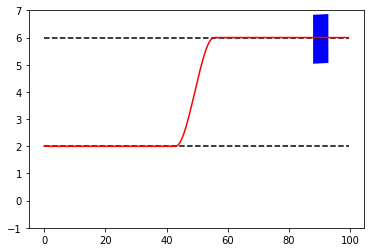

In [ ]:
ego = Vehicle(INIT_STATE)

START_LANE_CHANGE = 40
lane_change = False


while ego.x < STOP:
  if ego.x > START_LANE_CHANGE and not lane_change:
    waypoint = lane_change_waypoint(lane_1, lane_2, [ego.x ,ego.y])
    lane_change = True
  if not lane_change:
    waypoint = lane_1
  
  ego.update(TARGET_SPEED, waypoint)
  plt.gca().cla()
  plt.plot(lane_1[:, 0], lane_1[:, 1],"k--")
  plt.plot(lane_2[:, 0], lane_2[:, 1],"k--")
  plt.plot(waypoint[:, 0], waypoint[:, 1],"r")
  ego_shape = ego.veh_shape()
  plt.fill(ego_shape[:, 0], ego_shape[:, 1], "b")
  plt.ylim((-1, 7))
  # plt.axis("equal")
  display.display(plt.gcf())
  display.clear_output(wait=True)

  time.sleep(0.01)
